In [3]:
# Модель, завдання якої - спрогнозувати продажі на основі історичних даних та інших змінних.
# Вирахувати оптимальний рівень залишків, відштовхуючись від обертаності та попередньо спрогнозованих продажів.
# Володіючи вищезгаданою інформацією, зрозуміти, на яку суму нам необхідно замовити товару з певної підгрупи
# на певний період часу. Наприклад, тиждень.
# Вирахувати частку постачальника в підгрупі - на яку суму нам замовляти у певного постачальника на тиждень.
# Циклізувати написаний для певної підгрупи код - в 1 клік отримувати агреговані 1вихідні дані (бюджет закупівель)
                                                                                        # по ен-ній к-ті підгруп

# Є 2 основні складові успішної роботи моделі:
    # 1. КОД
    # 2. ВХІДНІ ДАНІ

# Вхідні дані, які використовує модель на даному етапі - це 2 excel-файли:
    # 1.) продажі у цінах закупівлі - історичні дані, вивантажені з ВІ:
                    # "собівартість" по всіх підгрупах ("Товар рівень 2 Повна назва") за вибраний період часу:
                    # січнІ-місяцІ 2017-2021 ---> 2017-2020==для навчання моделі; 2021==для порівняння прогнозу з фактом)
    # 2.) матриця незалежних змінних (наприклад, тренд, погода, святкові дні, вихідні і тд...)

# Код можна прочитати нижче. До кожного його кроку є максимально детальне пояснення.




# завантажуємо пекеджі
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# завантаження вхідних даних з ВІ
data_m = pd.read_excel (r'C:\Users\Maksym\Desktop\20.01.2021\multiple lin reg\2021_zagalna_podenna_model\input\input_data_original.xlsx')
# стовбець "Товарообіг" = реальний, нормальний ТО

# ЦЕЙ КОД:
# 1. ЗАВАНТАЖУЄ ПЕКЕДЖІ ТА INPUT-ДАНІ.
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

data_m

,Дата,Товарообіг
0,2017-01-01,NaN
1,2017-01-02,NaN
2,2017-01-03,NaN
3,2017-01-04,NaN
4,2017-01-05,NaN
...,...,...
2173,2022-12-27,27.0
2174,2022-12-28,28.0
2175,2022-12-29,29.0
2176,2022-12-30,30.0


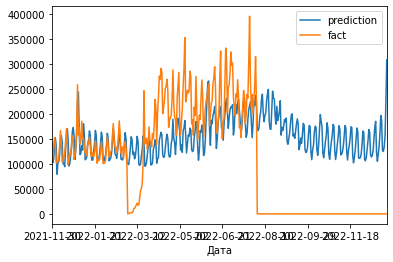

In [4]:
krok = 363 # к-ть робочих днів у періоді часу, з яким ми працюємо, кожного року (за винятком можливих неробочих днів(Різдво) або днів, які нам не потрібні 29/02/2020)
train_set_days_1 = (krok*1) #363 # в якому році починається тренувальна вибірка: 0=2017-20, 30=2018-20, 60=2019-20, 90=2020 
train_set_days_2 = ((krok*5)-31) #1994 # в якому році закінчується тренувальна вибірка
test_set_days_1 = ((krok*5)-31) #1994 # в якому році починається тестова вибірка
test_set_days_2 = (krok*6) #2025 # в якому році закінчується тестова вибірка

# пояснення, які числа слід вписувати у блоку коду, що над цим текстом.
# [(krok*0):(krok*1),:] = 2017
# [(krok*1):(krok*2),:] = 2018
# [(krok*2):(krok*3),:] = 2019
# [(krok*3):(krok*4),:] = 2020
# [(krok*4):(krok*5),:] = 2021
# [(krok*5):(krok*6),:] = 2022


# екстрагуємо/виокремлюємо залежну змінну, в тому чи іншому типі ціни
zalezhna_zminna = data_m['Товарообіг']
# zalezhna_zminna = data_m['Товарообіг в цінах закупки']

# скорочуємо назву вектора залежної змінної
zz = zalezhna_zminna

# перетворюємо zz у !датафрейм!. Це необхідно для приєднання цього вектору зал.змінн.до матриці незал. змінних, яка є !датафреймом!.
# zz = pd.DataFrame(zz)

# завантажуємо xlsx-файл із матрицею незалежних змінних
nezalezhni_zminni = pd.read_excel (r'C:\Users\Maksym\Desktop\20.01.2021\multiple lin reg\2021_zagalna_podenna_model\input\nezalezhni_zminni.xlsx')

# зберігаємо у csv-форматі щойно завантажену матрицю незалежних змінних
nezalezhni_zminni.to_csv (r'C:\Users\Maksym\Desktop\20.01.2021\multiple lin reg\2021_zagalna_podenna_model\promizhni\nezalezhni_zminni.csv', index = None, header=True)

# зчитуємо щойно збережений csv-файл із матрицею незалежних змінних
nezalezhni_zminni = pd.read_csv(r'C:\Users\Maksym\Desktop\20.01.2021\multiple lin reg\2021_zagalna_podenna_model\promizhni\nezalezhni_zminni.csv')

# додаємо zz(залежну змінну) до матриці nezalezhni_zminni(незалежних змінних)
nezalezhni_zminni['zz'] = zz

# # # називаємо матрицю-суміш залежних і незалежних змінних (загальний масив даних) "таблиця"
tablytsia = nezalezhni_zminni

# # робимо перший стовбець матриці індексом
tablytsia = tablytsia.set_index('Дата')

# # створюємо тренувальну вибірку - обрізаємо масив
train_set = tablytsia.iloc[(train_set_days_1):(train_set_days_2),:]

# # створюємо тестову вибірку - обрізаємо масив
test_set = tablytsia.iloc[(test_set_days_1):(test_set_days_2),:]

# # тренувальна вибірка, незалежні змінні
X_train = train_set.drop(['zz'], axis=1)

# # тренувальна вибірка, залежна змінна + перетворення її у датафрейм
y_train = train_set.zz
y_train = pd.DataFrame(y_train)

# # тестова вибірка, незалежні змінні
X_test = test_set.drop(['zz'], axis=1)

# # тестова вибірка, залежна змінна + перетворення її у датафрейм
y_test = test_set.zz
y_test = pd.DataFrame(y_test)

# завантаження пакету для лінійної регресії
from sklearn.linear_model import LinearRegression

# запуск моделі лінійної регресії
regr = LinearRegression()

# фіттинг екзо- та ендогенних змінних тренувальної вибірки за моделлю лінійної регресії
regr.fit(X_train, y_train)

# демонстрація регресійних константи та коефіцієнтів
# print('Intercept: \n', regr.intercept_)
# print('Coefficients: \n', regr.coef_)

# надання назв регресійним константі та коефіцієнтам
const = regr.intercept_
coefs = regr.coef_

# # перемноження значень незалежних змінних тестової вибірки на регресійні коефіцієнти - отримання "матриці перемножень"
aa = X_test*coefs

# # генерування прогнозу - через сумування рядків "матриці перемножень" та додавання до кожного з них константи
prediction = aa.sum(axis=1, skipna=True) + const

# # перетворення прогнозу у датафрейм + корекція похибки у зв'язку з гіпотетичним! падінням глобального тренду споживання
prediction = pd.DataFrame(prediction)

# надання назви першому(у пайтоні - нульовому) стовбцю у датафреймі - "prediction"
prediction.rename(columns={0:'prediction'}, inplace=True)

# додавання стовбця з фактичними продажами у датафрейм прогнозу
prediction['fact'] = y_test

# # калькуляція відсоткової похибки
# pokhybka = (( (prediction['prediction']) / (prediction['fact']) )-1)

# # приведення вектора відсоткової похибки до модулю
# pokhybka_abs = pokhybka.abs()

# # зображення датафрейму прогнозу(і факту) на графіку
prediction.plot()

# # калькуляція середньої похибки
# ser_pokhybka_abs = pokhybka_abs.mean()
# ser_pokhybka = pokhybka.mean()

# # заокруглення значення середньої похибки до n знаків
# ser_pokhybka_abs = round(ser_pokhybka_abs, 4)
# ser_pokhybka = round(ser_pokhybka, 4)

# # додавання стовбця з %похибками у датафрейм прогнозу
# # prediction['відхилення по модулю, %'] = pokhybka_abs
# # prediction['відхилення не по модулю, %'] = pokhybka
# # prediction['ser_pokhybka_abs, %'] = ser_pokhybka_abs
# # prediction['ser_pokhybka, %'] = ser_pokhybka

# creatind DataFrame for saving only prediction
prediction1 = pd.DataFrame(prediction.prediction)

# збереження датафрейму прогнозу у xlsx-файл
prediction.to_excel (r'C:\Users\Maksym\Desktop\20.01.2021\multiple lin reg\2021_zagalna_podenna_model\output\xlsx\p_sales.xlsx', index = True, header=True)

# # демонстрація середньої похибки
# print("СЕРЕДНЯ ПОХИБКА ПРОГНОЗУВАННЯ ВІДНОСНО ФАКТУ ПО МОДУЛЮ:\n", ser_pokhybka_abs)
# print("СЕРЕДНЯ ПОХИБКА ПРОГНОЗУВАННЯ ВІДНОСНО ФАКТУ не!по модулю:\n", ser_pokhybka)



# # ЦЕЙ ФРАГМЕНТ КОДУ:
# # 1. ГЕНЕРУЄ ПРОГНОЗ ПРОДАЖІВ.
# # 2. ЗБЕРІГАЄ ПРОГНОЗ ПРОДАЖІВ У ЕКСЕЛЬ ФАЙЛ. РАЗОМ ІЗ СТОВБЦЯМИ 'ФАКТ' І 'ВІДХИЛЕННЯ'.
# ###########################################################################################################################
# ###########################################################################################################################
# ###########################################################################################################################